# Section 6 - Robinson Compass FRCNN

This section uses the Robinson Compass edge detection algorithm in the same manner as the aforementioned Canny Algorithm.  The algorithm seeks to highlight target edges based on some threshold using eight different kernels highlighting edges based on the eight primary compass directions.  We anticipate comparable results to the Canny method since RC will consider edges from eight different directions across a gradient image rather than the approach Canny takes. 

## 6.1 - Robinson Compass Overview

Robinson Compass relies on using kernels that highlight edges focused on a specified direction using Compass directions to select them.  There are eight kernels corresponding to eight compass directions.

The Robinson Compass implementation was inspired from the following link: https://medium.com/@erhan_arslan/exploring-edge-detection-in-python-3-compass-edge-detector-edf8721a7825

In [1]:
# Utility Imports
import os, sys
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import cv2

project_path = pathlib.Path.cwd().parent.resolve().parent.resolve()
print(f"Project path: {project_path}")

sys.path.append(os.path.join(project_path, "src", "frcnn"))
sys.path.append(os.path.join(project_path, "src", "utils"))

# Data Handling Imports
from SeaSarFRCNN import SeaSarFRCNN
from ModelWorker import ModelWorkerFRCNN
from WorkspaceManager import WorkspaceManager

# Model and Model Utility Imports
import torchvision
import torch
from frcnn_models import RobinsonFRCNN, RobinsonCompass



Project path: /home/jag1799/Documents/vscode_ws/school/ai_570/SeaSARR


/home/jag1799/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
workspace_builder = WorkspaceManager()
workspace_builder.run_setup()

if not os.path.exists(workspace_builder._data_path):
    raise FileNotFoundError(f"Not able to find data directory at path: {workspace_builder._data_path}")
else:
    print(f"Using data path: {workspace_builder._data_path}")

Project path: /home/jag1799/Documents/vscode_ws/school/ai_570/SeaSARR
Found existing data path at /home/jag1799/Documents/vscode_ws/school/ai_570/SeaSARR/data/kaggle
Using data path: /home/jag1799/Documents/vscode_ws/school/ai_570/SeaSARR/data/kaggle/SARscope


In [3]:
# Validation Path retrieval
tester_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
train_annotations = os.path.join(workspace_builder._data_path, "annotations", "train_annotations.coco.json")
train_images = os.path.join(workspace_builder._data_path, "train")

train_data = SeaSarFRCNN(train_images, train_annotations, tester_transforms)

loading annotations into memory...
Done (t=0.19s)
creating index...
index created!


## 6.2 - Data Overview

Below, we can see that some images are easier to extract primary targets.  The target edges are thick and resemble blobs more, likely making it easier for the FRCNN model to detect them.

In [4]:
rob_comp = RobinsonCompass((3, 3), 1, 500)

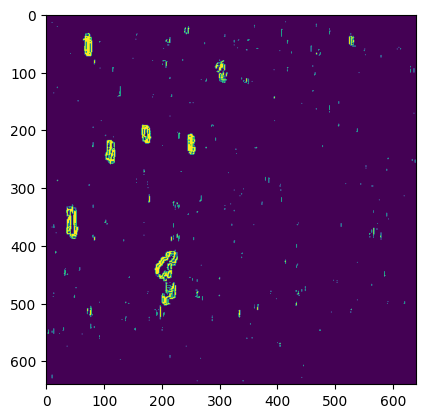

In [5]:
image, target = train_data._get_image(3270, True, False)
image = np.array(image)
edges = rob_comp.get_detections(image)
plt.imshow(edges)

### 6.2.1 - False Positives

Like the Canny method, the compass method also suffers from the thresholding issue.  Below the same image shows even more false edges in the image.  This in turn may prove our original hypothesis wrong about RC since there will be far more confuser information present.

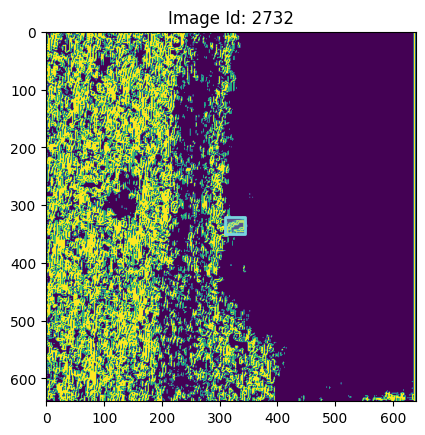

In [6]:
image, target = train_data._get_image(2732, get_image=True)
image = np.array(image)
edges = rob_comp.get_detections(image)
plt.imshow(edges)

## 6.3 - Model Construction and Training

In [7]:
# Set up train dataloader
train_data = torchvision.datasets.wrap_dataset_for_transforms_v2(train_data, target_keys=("boxes", "labels"))
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=True, collate_fn=train_data._packager)

In [8]:
# Build the baseline model
frcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
input_features = frcnn.roi_heads.box_predictor.cls_score.in_features
frcnn.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(input_features, 2)

# Build the loss function and optimizer
optimizer = torch.optim.Adam(frcnn.parameters(), lr=0.001)

/home/jag1799/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jag1799/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
rob_comp_model = RobinsonFRCNN(frcnn, 'cuda', (3, 3), 1, 500)
worker = ModelWorkerFRCNN(optimizer, rob_comp_model, False)

In [10]:
worker.train(train_dataloader, num_epochs=1, indices_to_skip=[3736])

Batch: 3735/4716 | Batch Loss: 0.37660652399063118

############# Epoch: 0 Complete #############
Total Epoch Combined Loss: 110328357.51298012
Loss Objectness: 2604436.2698205784
RPN Region Proposal Losses: 1354142.1495224326
Classifier Loss: 4393609.465323111
Bounding Box Region Loss: 101976173.00222516




In [12]:
# Validation Path retrieval
tester_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
validation_annotations = os.path.join(workspace_builder._data_path, "annotations", "valid_annotations.coco.json")
validation_images = os.path.join(workspace_builder._data_path, "validation")

validation_data = SeaSarFRCNN(validation_images, validation_annotations, tester_transforms)

# Set up train dataloader
validation_data = torchvision.datasets.wrap_dataset_for_transforms_v2(validation_data, target_keys=("boxes", "labels"))
validation_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=1, shuffle=True, collate_fn=validation_data._packager)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [ ]:
worker.validation(validation_dataloader, num_epochs=1)

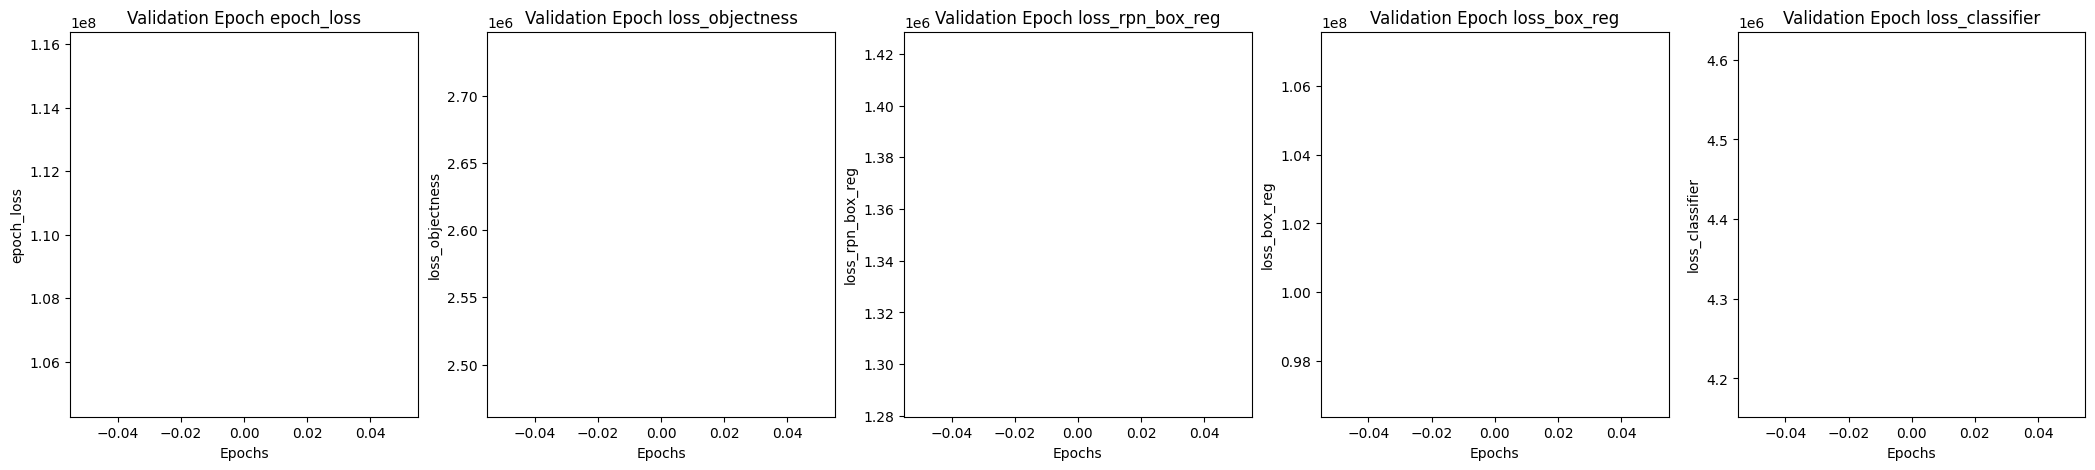

In [13]:
worker.plot_losses(False)